In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree
from scipy.stats import entropy
import itertools

from utils.ply import write_ply, read_ply, check_with_colors_and_intensity
from fileutils import dict_to_str, give_filename, parse_filename
%load_ext autoreload
%aimport subsampling
%aimport matching
%aimport features
%aimport subsampling

import time
import os

data_path = '../data'
saved_data_path = '../saved_data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
filename = 'covariance_bildstein3_factor:0.2-q:0.95-radius:0.3-subs:decimation-t0:0.268.npy'
filename = 'covariance_bildstein1_factor:0.2-q:0.95-radius:0.3-subs:decimation-t0:0.268.npy'
covariances_ = np.load(os.path.join(saved_data_path, filename))
covariances_.shape

(6225, 10, 10)

### Experiment 1: positive and negative values for covariance lowest eigenvalues

In [142]:
min_eigenvalues = np.linalg.eigh(covariances_)[0].min(axis=1)
max_eigenvalues = np.linalg.eigh(covariances_)[0].max(axis=1)
dets = np.abs(np.linalg.det(covariances_))

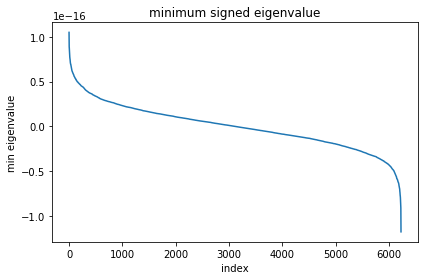

In [149]:
plt.plot(sorted(min_eigenvalues)[::-1])
plt.xlabel('index')
plt.ylabel('min eigenvalue')
plt.title('minimum signed eigenvalue')

plt.tight_layout()
plt.savefig('../images/min_signed_eigenvalue.png')
plt.show()

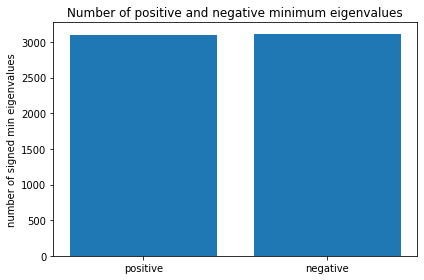

In [150]:
plt.bar(['positive', 'negative'],
        [(min_eigenvalues>0).sum(), (min_eigenvalues<=0).sum()])
# plt.bar(*np.unique(np.sign(min_eigenvalues), return_counts=True))
plt.ylabel('number of signed min eigenvalues')
plt.title('Number of positive and negative minimum eigenvalues')

plt.tight_layout()
plt.savefig('../images/pos_neg_eigenvalue.png')
plt.show()

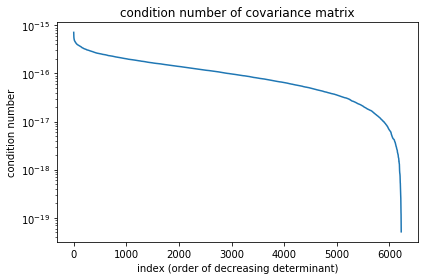

In [151]:
min_eigenvalues = np.abs(np.linalg.eigh(covariances_)[0]).min(axis=1)
max_eigenvalues = np.abs(np.linalg.eigh(covariances_)[0]).max(axis=1)

plt.plot(sorted(min_eigenvalues/max_eigenvalues)[::-1])
plt.xlabel('index (order of decreasing determinant)')
plt.ylabel('condition number')
plt.yscale('log')
plt.title('condition number of covariance matrix')

plt.tight_layout()
plt.savefig('../images/condition_number.png')
plt.show()

### Experiment 2: removing one feature from the covariance matrix

In [156]:
features = {k:v for k,v in enumerate(['a1', 'a2', 'a3', 'alpha', 'beta', 'gamma', 'red', 'green', 'blue', 'intensity'])}
dim = covariances.shape[-1]
dets = {}

for i in range(dim+1):
    if i==dim:
        cov = covariances.copy()
    else:
        cov = np.delete(np.delete(covariances.copy(), i, axis=1), i, axis=2)
        
    dets[i] = np.abs(np.linalg.det(cov))

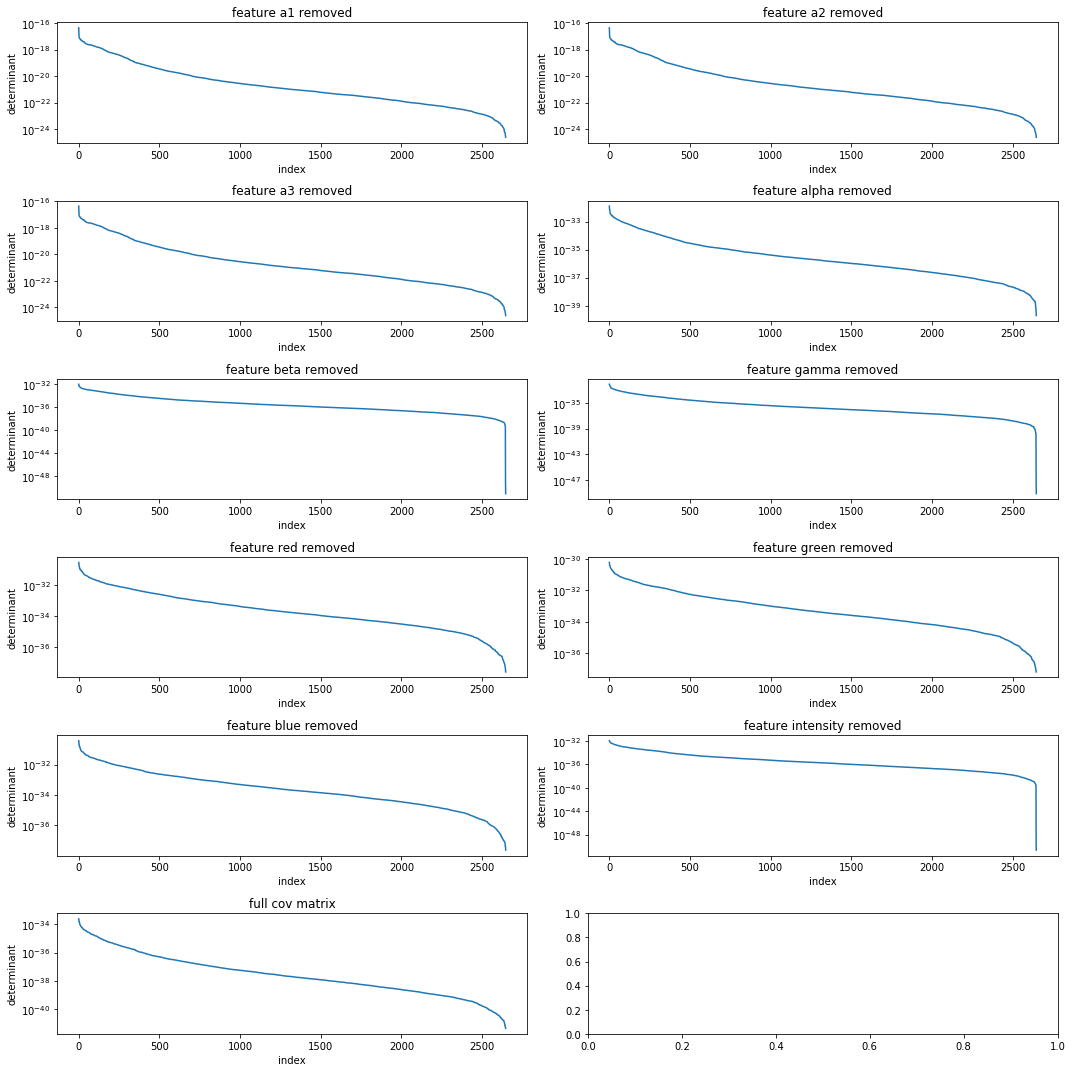

In [160]:
ncols = 2
nrows = (dim+1)//ncols + (dim+1)%ncols
fig, ax = plt.subplots(nrows, ncols, figsize = (15,15))

for k in range(dim+1):
    i = k//ncols
    j = k%ncols
    ax[i,j].plot(sorted(dets[k])[::-1])
    ax[i,j].set_yscale('log')
    ax[i,j].set_ylabel('determinant')
    ax[i,j].set_xlabel('index')
    if k==dim:
        ax[i,j].set_title('full cov matrix')
    else:
        ax[i,j].set_title('feature {} removed'.format(features[k]))

plt.tight_layout()
plt.savefig('../images/determinant_without_features.png')
plt.show()

In [99]:
indices = {}
jacs = {}

for i in range(dim+1):
    indices[i] = np.argsort(np.abs(dets[i]))[::-1]
        
for i,j in itertools.combinations(range(dim+1), 2):
#     jacs['{}-{}'.format(i,j)] = [jaccard_similarity(indices[i][:k], indices[j][:k]) for k in range(1,min(100,len(indices[i])))]
    jacs[(i,j)] = [jaccard_similarity(indices[i][:k], indices[j][:k]) for k in range(1,min(10000,len(indices[i])))]

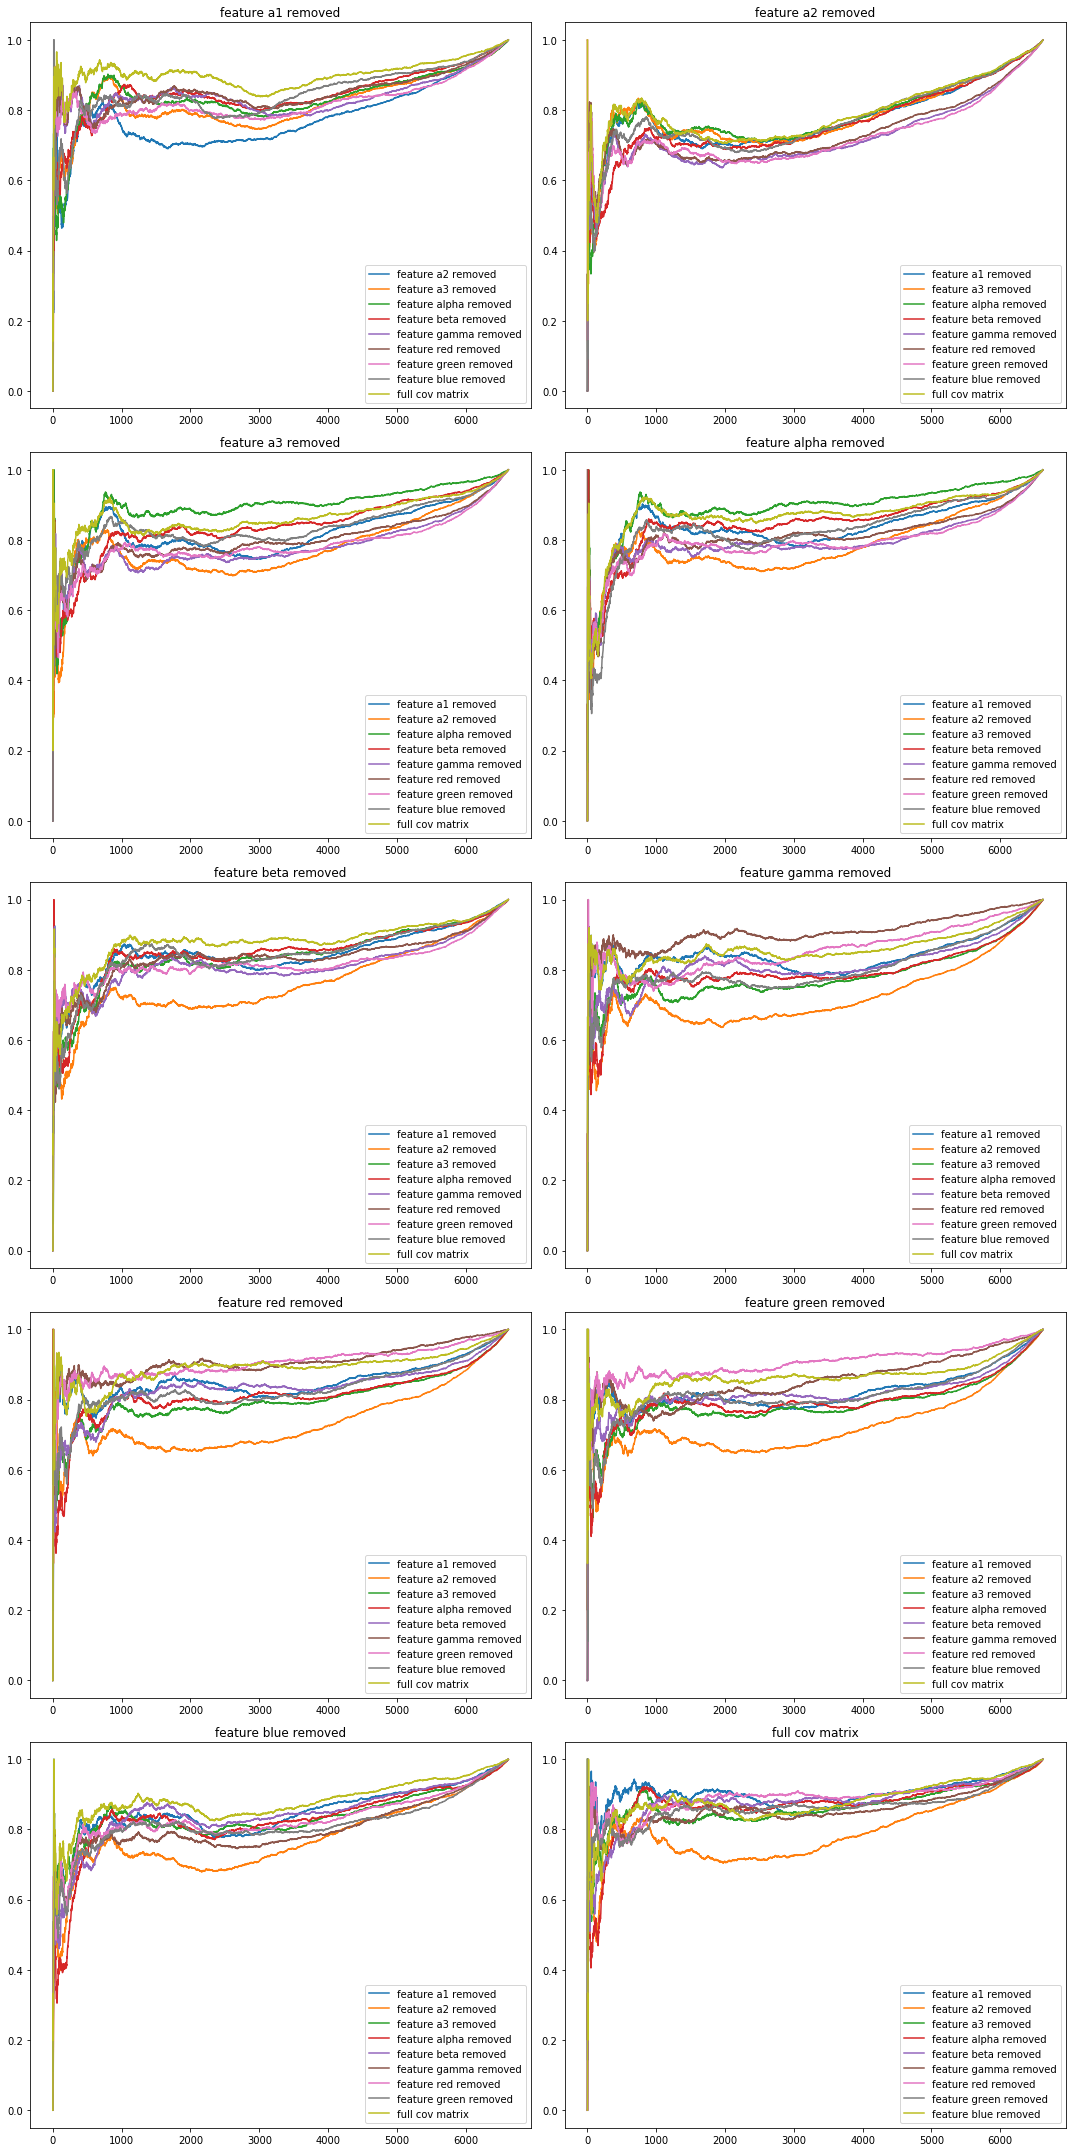

In [100]:
def give_label(i, dim):
    if i==dim:
        return 'full cov matrix'
    else:
        return 'feature {} removed'.format(features[i])

ncols = 2
nrows = (dim+1)//ncols + (dim+1)%ncols
fig, ax = plt.subplots(nrows, ncols, figsize = (15,30))

for k,l in itertools.combinations(range(dim+1), 2):
    i = k//ncols
    j = k%ncols
    ax[i,j].plot(jacs[(k,l)], label=give_label(l, dim))
    
    i = l//ncols
    j = l%ncols
    ax[i,j].plot(jacs[(k,l)], label=give_label(k, dim))
    
for k in range(dim+1):
    i = k//ncols
    j = k%ncols
    ax[i,j].set_title(give_label(k, dim))
    ax[i,j].legend()

plt.tight_layout()

### Experiment 3: use of different methods of numpy to get the determinant

In [46]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# def cum_jaccard(l1,l2, n):
#     jac=[]
#     current_set_1 = set()
#     current_set_2 = set()
#     for i in range(1,n):
#         current_set_1.union(set(l1[]))

### Sub-experience 1: use of classical covariance

In [162]:
filename = 'covariance_bildstein1_factor:0.2-q:0.95-radius:0.3-subs:decimation-t0:0.268.npy'

covariances = np.load(os.path.join(saved_data_path, filename))
covariances.shape

(6225, 10, 10)

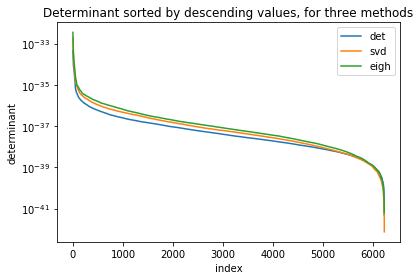

In [165]:
dets = np.abs(np.linalg.det(covariances))
dets2 = np.abs(np.linalg.svd(covariances, compute_uv=False, hermitian=True)).prod(axis=1)
dets3 = np.abs(np.linalg.eigh(covariances)[0]).prod(axis=1)

plt.plot(sorted(dets)[::-1], label='det')
plt.plot(sorted(dets2)[::-1], label='svd')
plt.plot(sorted(dets3)[::-1], label='eigh')
plt.xlabel('index')
plt.ylabel('determinant')
plt.title('Determinant sorted by descending values, for three methods')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig('../images/determinants_numpy_methods.png')
plt.show()

In [164]:
indices = np.argsort(np.abs(dets))[::-1]
indices2 = np.argsort(np.abs(dets2))[::-1]
indices3 = np.argsort(np.abs(dets3))[::-1]

jac12 = [jaccard_similarity(indices[:i], indices2[:i]) for i in range(1,min(10000,len(indices)))]
jac13 = [jaccard_similarity(indices[:i], indices3[:i]) for i in range(1,min(10000,len(indices)))]
jac23 = [jaccard_similarity(indices2[:i], indices3[:i]) for i in range(1,min(10000,len(indices)))]

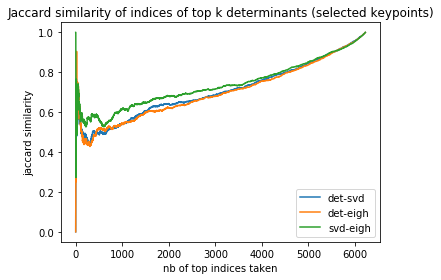

In [166]:
plt.plot(jac12, label='det-svd')
plt.plot(jac13, label='det-eigh')
plt.plot(jac23, label='svd-eigh')
plt.xlabel('nb of top indices taken')
plt.ylabel('jaccard similarity')
plt.title('Jaccard similarity of indices of top k determinants (selected keypoints)')
plt.legend()

plt.tight_layout()
plt.savefig('../images/jaccard_numpy_methods.png')
plt.show()

### Subexperience 2: use of covariance where we remove a1 feature

In [50]:
covariances = np.load(os.path.join(saved_data_path, filename))
covariances = np.delete(np.delete(covariances, 0, axis=1), 0, axis=2)
covariances.shape

(6620, 9, 9)

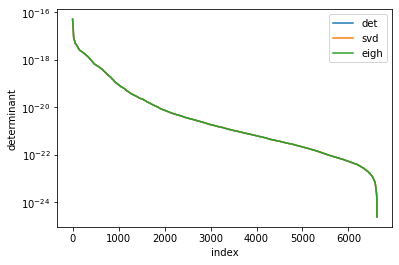

In [51]:
dets = np.abs(np.linalg.det(covariances))
dets2 = np.abs(np.linalg.svd(covariances, compute_uv=False, hermitian=True)).prod(axis=1)
dets3 = np.abs(np.linalg.eigh(covariances)[0]).prod(axis=1)

plt.plot(sorted(dets)[::-1], label='det')
plt.plot(sorted(dets2)[::-1], label='svd')
plt.plot(sorted(dets3)[::-1], label='eigh')
plt.xlabel('index')
plt.ylabel('determinant')
plt.yscale('log')
plt.title('Determinant sorted by descending values, for three methods')
plt.legend()
plt.show()

In [52]:
indices = np.argsort(np.abs(dets))[::-1]
indices2 = np.argsort(np.abs(dets2))[::-1]
indices3 = np.argsort(np.abs(dets3))[::-1]

jac12 = [jaccard_similarity(indices[:i], indices2[:i]) for i in range(1,min(10000,len(indices)))]
jac13 = [jaccard_similarity(indices[:i], indices3[:i]) for i in range(1,min(10000,len(indices)))]
jac23 = [jaccard_similarity(indices2[:i], indices3[:i]) for i in range(1,min(10000,len(indices)))]

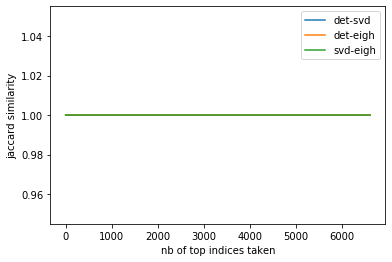

In [53]:
plt.plot(jac12, label='det-svd')
plt.plot(jac13, label='det-eigh')
plt.plot(jac23, label='svd-eigh')
plt.xlabel('nb of top indices taken')
plt.ylabel('jaccard similarity')
plt.title('Jaccard similarity of indices of top k determinants (selected keypoints)')
plt.legend()

### Experiment 4: add diagonal elements to covariance matrix to make it better conditioned

In [112]:
filename = 'covariance_bildstein3_factor:0.2-q:0.95-radius:0.3-subs:decimation-t0:0.268.npy'

covariances1 = np.load(os.path.join(saved_data_path, filename))
covariances2 = covariances1.copy() + np.identity(covariances1.shape[-1])*0.00001

In [116]:
dets1 = np.abs(np.linalg.det(covariances1))
dets2 = np.abs(np.linalg.det(covariances2))

indices1 = np.argsort(np.abs(dets1))[::-1]
indices2 = np.argsort(np.abs(dets2))[::-1]

jac12 = [jaccard_similarity(indices1[:i], indices2[:i]) for i in range(1,min(10000,len(indices)))]

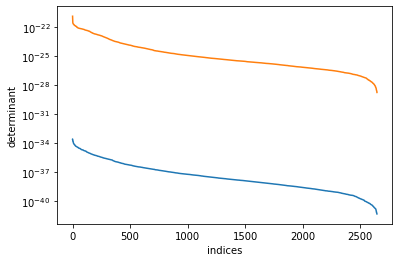

In [121]:
plt.plot(sorted(dets1)[::-1])
plt.plot(sorted(dets2)[::-1])
plt.yscale('log')
plt.xlabel('indices')
plt.ylabel('determinant')

plt.show()

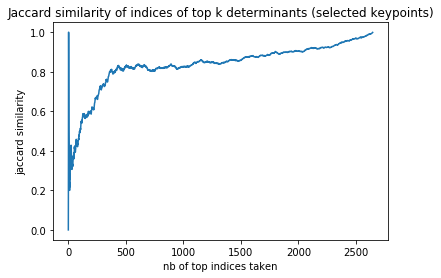

In [123]:
plt.plot(jac12)
plt.xlabel('nb of top indices taken')
plt.ylabel('jaccard similarity')
plt.title('Jaccard similarity of indices of top k determinants (selected keypoints)')

plt.show()